
Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.05	-###TEST.TreeAnc.prepare_tree: BEGIN

0.99	-SequenceData: loaded alignment.
1.00	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.00	-SeqData: making compressed alignment...

3.24	-SequenceData: constructed compressed alignment...
3.48	--ClockTree: Setting precision to level 2

3.55	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
3.81	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481

3.83	-###TEST.TreeAnc.prepare_tree: BEGIN


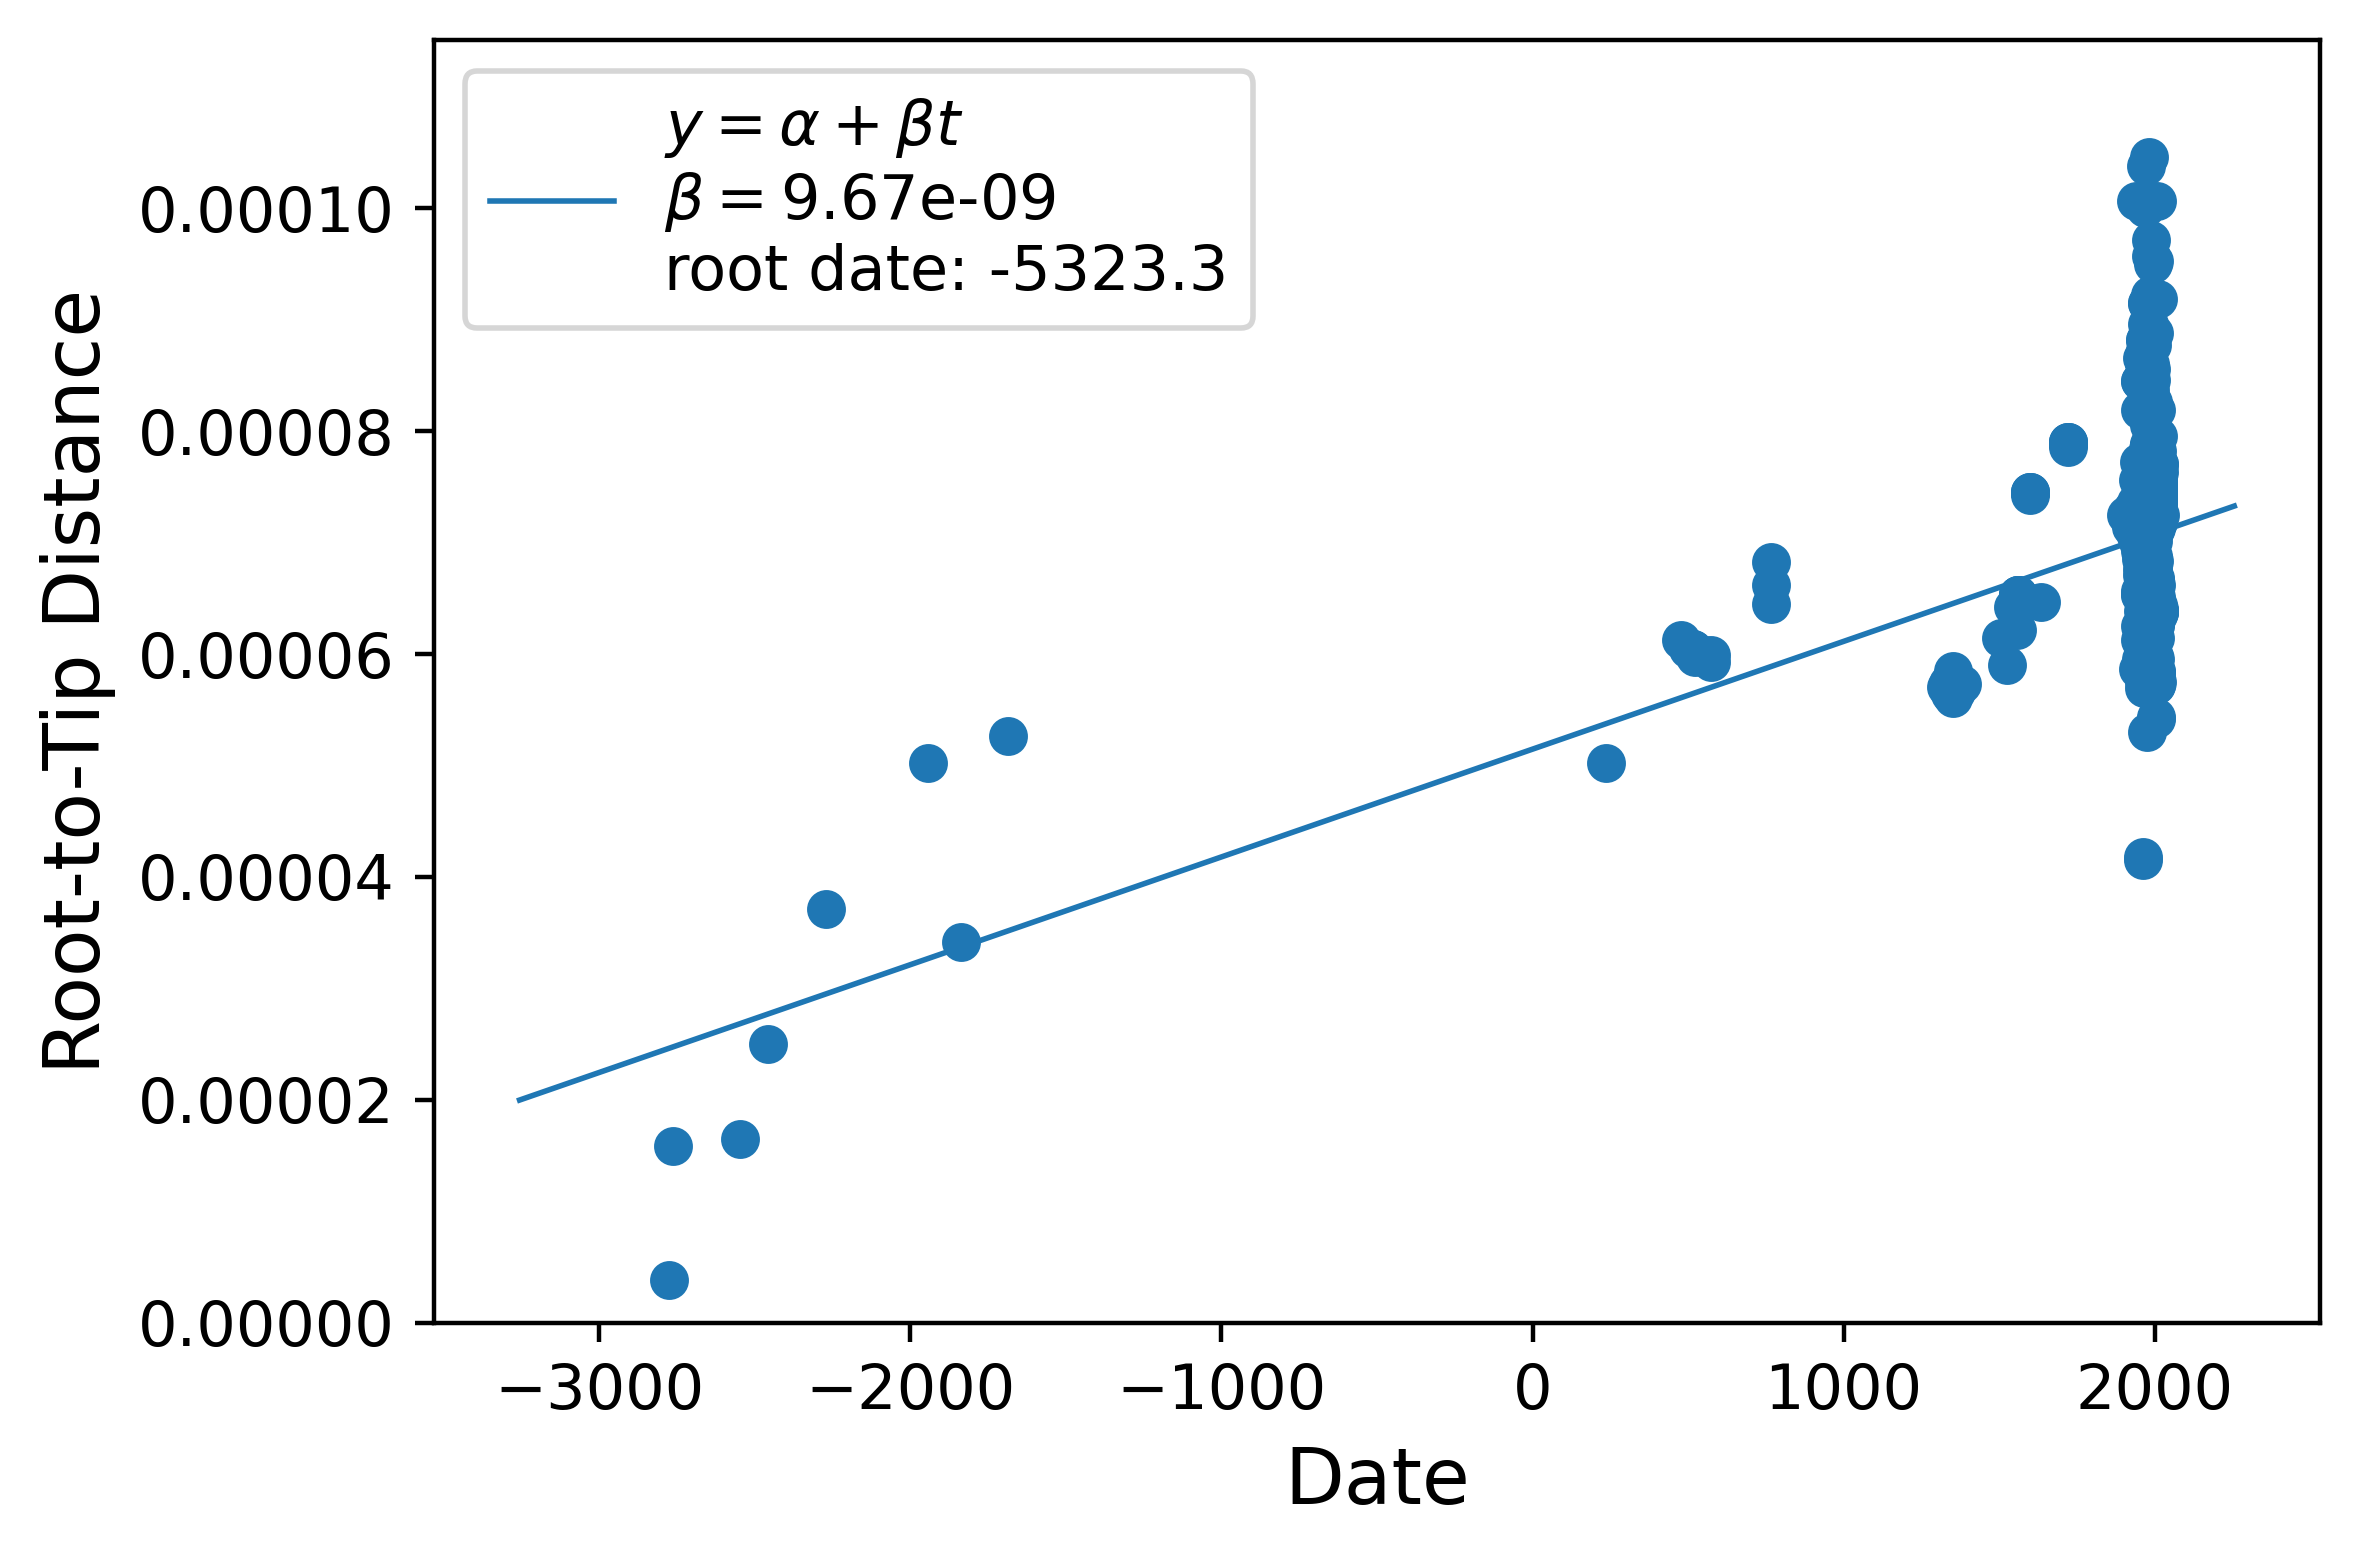

In [23]:
import treetime
import matplotlib.pyplot as plt
from Bio import Phylo
import os
import numpy as np

tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
aln_path = "test/test.fasta"
outdir = "../../docs/results/latest/timetree/"

plt.rc('lines', linewidth=1)
dpi = 400

DATE_COL = "Date"
NAME_COL = "Sample"
REF_DATE = 1992.0
REF_LEN = 4653728
N_IQD=3

# Create a basic TimeTree Object
dates = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)
dates["Reference"] = REF_DATE

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,
                       tree=tree_path, 
                       #gtr="infer", 
                       seq_len=REF_LEN,
                       verbose=4, 
                       fill_overhangs=False)

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False)

# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)
tt.plot_root_to_tip(
    ax=ax1,
    )
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")

out_path = os.path.join(outdir, "timetree_rtt.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [27]:
# Run time tree analysis
BL_MODE = "input"
tt.run()
# OR
# tt.run(branch_length_mode=BL_MODE)


188.70	-TreeTime._set_branch_length_mode: maximum branch length is 5.054e-05,
      	 using branch length mode joint

188.70	-TreeAnc.optimize_tree: sequences...

188.70	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint
188.70	--TreeAnc.infer_gtr: counting mutations...
189.69	---TreeAnc.infer_gtr: counting mutations...done

189.69	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
189.69	--GTR: ambiguous character: N
189.69	---GTR: init with dummy values!

189.69	-GTR: model inference
189.69	---GTR inference iteration 0 change: 0.447213595499958
189.69	---GTR inference iteration 1 change: 0.24246715462459986
189.69	---GTR inference iteration 2 change: 0.0005052984331835863
189.69	---GTR inference iteration 3 change: 5.903535938480987e-05
189.69	---GTR inference iteration 4 change: 4.266077378667631e-05
189.69	--The model allows for gaps which are estimated to occur at a low
      	  fraction of 5.491e-04 this can potentially result in artificats. gap
      	  fraction w

280.52	-TEST.ClockTree.convert_dates -- numdate: 1865.820523520175

280.52	-TEST.ClockTree.convert_dates -- date: 1865-10-27

280.52	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_006546745.1_ASM654674v1_genomic years_bp31.047945205479426

280.52	-TEST.ClockTree.convert_dates -- numdate: 1990.0

280.52	-TEST.ClockTree.convert_dates -- date: 1990-01-01

280.52	-TEST.ClockTree.convert_dates -- node name: NODE825
      	 years_bp49.04782938034556

280.52	-TEST.ClockTree.convert_dates -- numdate: 1972.000115825134

280.52	-TEST.ClockTree.convert_dates -- date: 1972-01-01

280.52	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_002981955.1_ASM298195v1_genomic years_bp49.04794520547944

280.52	-TEST.ClockTree.convert_dates -- numdate: 1972.0

280.52	-TEST.ClockTree.convert_dates -- date: 1972-01-01

280.52	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_002981895.1_ASM298189v1_genomic years_bp49.04794520547944

280.52	-TEST.ClockTree.convert_dates -- numdate: 1972.0




280.73	-TEST.ClockTree.convert_dates -- numdate: 2015.0

280.73	-TEST.ClockTree.convert_dates -- date: 2015-01-01

280.73	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_003074215.1_ASM307421v1_genomic years_bp6.0479452054794365

280.73	-TEST.ClockTree.convert_dates -- numdate: 2015.0

280.73	-TEST.ClockTree.convert_dates -- date: 2015-01-01

280.73	-TEST.ClockTree.convert_dates -- node name: NODE380
      	 years_bp1034.174440479415

280.73	-TEST.ClockTree.convert_dates -- numdate: 986.8735047260645

280.73	-TEST.ClockTree.convert_dates -- date: 0986-11-15

280.73	-TEST.ClockTree.convert_dates -- node name: NODE530
      	 years_bp784.4754936927545

280.73	-TEST.ClockTree.convert_dates -- numdate: 1236.572451512725

280.73	-TEST.ClockTree.convert_dates -- date: 1236-07-28

280.73	-TEST.ClockTree.convert_dates -- node name: NODE562
      	 years_bp285.17787433091337

280.73	-TEST.ClockTree.convert_dates -- numdate: 1735.870070874566

280.73	-TEST.ClockTree.convert_dates -- dat


280.94	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_006376475.1_ASM637647v1_genomic years_bp53.04794520547943

280.94	-TEST.ClockTree.convert_dates -- numdate: 1968.0

280.94	-TEST.ClockTree.convert_dates -- date: 1968-01-01

280.94	-TEST.ClockTree.convert_dates -- node name: NODE418
      	 years_bp55.013129986524646

280.94	-TEST.ClockTree.convert_dates -- numdate: 1966.0348152189547

280.94	-TEST.ClockTree.convert_dates -- date: 1966-01-13

280.94	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_001188735.1_ASM118873v1_genomic years_bp45.04782938034556

280.94	-TEST.ClockTree.convert_dates -- numdate: 1976.000115825134

280.94	-TEST.ClockTree.convert_dates -- date: 1976-01-01

280.94	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_001617805.1_Yersinia_pestis_173_genomic years_bp43.04794520547944

280.94	-TEST.ClockTree.convert_dates -- numdate: 1978.0

280.94	-TEST.ClockTree.convert_dates -- date: 1978-01-01

280.94	-TEST.ClockTree.convert_dates -- node na


281.15	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324425.1_ASM32442v1_genomic years_bp39.04794520547944

281.15	-TEST.ClockTree.convert_dates -- numdate: 1982.0

281.15	-TEST.ClockTree.convert_dates -- date: 1982-01-01

281.15	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324625.1_ASM32462v1_genomic years_bp30.047945205479436

281.15	-TEST.ClockTree.convert_dates -- numdate: 1991.0

281.15	-TEST.ClockTree.convert_dates -- date: 1991-01-01

281.15	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324865.1_ASM32486v1_genomic years_bp37.04794520547944

281.15	-TEST.ClockTree.convert_dates -- numdate: 1984.0

281.15	-TEST.ClockTree.convert_dates -- date: 1984-01-01

281.15	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000325405.1_ASM32540v1_genomic years_bp26.047945205479436

281.15	-TEST.ClockTree.convert_dates -- numdate: 1995.0

281.16	-TEST.ClockTree.convert_dates -- date: 1995-01-01

281.16	-TEST.ClockTree.convert_dates -- node name:
  


281.41	-TEST.ClockTree.convert_dates -- numdate: -9.073004354323302

281.41	-TEST.ClockTree.convert_dates -- date: -010-12-05

281.41	-TEST.ClockTree.convert_dates -- node name: NODE893
      	 years_bp894.6529491326264

281.41	-TEST.ClockTree.convert_dates -- numdate: 1126.394996072853

281.41	-TEST.ClockTree.convert_dates -- date: 1126-05-25

281.41	-TEST.ClockTree.convert_dates -- node name: NODE907
      	 years_bp45.53986160332077

281.41	-TEST.ClockTree.convert_dates -- numdate: 1975.5080836021586

281.41	-TEST.ClockTree.convert_dates -- date: 1975-07-05

281.41	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324665.1_ASM32466v1_genomic years_bp21.047945205479436

281.41	-TEST.ClockTree.convert_dates -- numdate: 2000.0

281.41	-TEST.ClockTree.convert_dates -- date: 2000-01-01

281.41	-TEST.ClockTree.convert_dates -- node name: NODE908
      	 years_bp29.775645612326155

281.41	-TEST.ClockTree.convert_dates -- numdate: 1991.2722995931533

281.41	-TEST.ClockTree.convert

'success'

In [28]:
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.0, clock_length=0.0, date='-4250-09-13', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

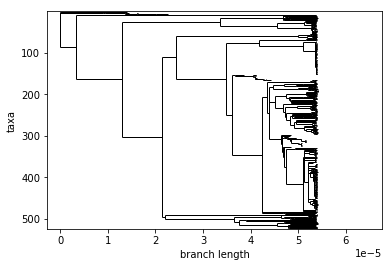

In [29]:
Phylo.draw(tt.tree, label_func=lambda x:'', show_confidence=False)

318.61	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


"step = 250\naxis_pad = 50\ndate_range = np.max([n.numdate for n in tt.tree.get_terminals()]) #- offset\nprint(date_range)\nax.set_xlim(-axis_pad,date_range+axis_pad)\nax.set_ylim(500,-50)\nax1.set_xlabel('year')\nax1.set_ylabel('')\nax1.set_yticks([])\n"

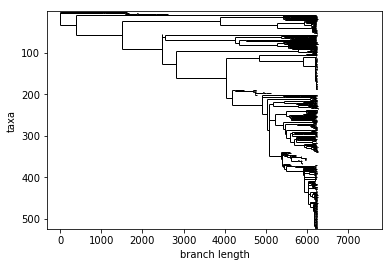

In [30]:
fig, ax1 = plt.subplots(1)

# Deepest nodes at the top
tt.tree.ladderize(reverse=False)
# Convert branch length to years
tt.branch_length_to_years()

# Draw tree to the canvas
Phylo.draw(tt.tree, 
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Problem #1: The x axis is not in the range root.numdate t maximum tip_date
# Problem #2: The x axis is in weird increments

"""step = 250
axis_pad = 50
date_range = np.max([n.numdate for n in tt.tree.get_terminals()]) #- offset
print(date_range)
ax.set_xlim(-axis_pad,date_range+axis_pad)
ax.set_ylim(500,-50)
ax1.set_xlabel('year')
ax1.set_ylabel('')
ax1.set_yticks([])
"""